## _Reco. Track Evaluation_

- evaluate track reconstruction of GNN
- we have reconstructed tracks from _`trkx_from_gnn.py`_ (see its code breakdown in _`trkx_from_gnn.ipynb`_)


This is code breakdown of _`eval_reco_trkx.py`_ by using the similar script from _`gnn4itk/scripts/eval_reco_trkx.py`_

In [1]:
import glob, os, sys, yaml

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import time

In [4]:
from sklearn.cluster import DBSCAN
from multiprocessing import Pool
from functools import partial

In [5]:
# select a device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
sys.path.append('..')

In [7]:
from src import SttTorchDataReader, SttCSVDataReader

### _(1) Tracks from GNN_

* from _`tracks_from_gnn.py`_

In [8]:
raw_inputdir="../run_all/fwp_gnn_processed/pred"  # output of GNN stage as in test/pred
rec_inputdir="../run_all/fwp_gnn_segmenting/seg"  # output of trkx_from_gnn.sh
outputdir="../run_all/fwp_gnn_segmenting/eval"    # output of eval_reco_trkx.sh

In [9]:
# reco_track_path = "run/trkx_from_gnn"
reco_trkx_reader = SttTorchDataReader(rec_inputdir)

In [10]:
# what are the events?
reco_trkx_reader.all_evtids[:10]

['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005']

In [11]:
# fetch a single event
reco_trkx_data = reco_trkx_reader(5)

In [12]:
reco_trkx_data.head()

,hit_id,track_id
0,28,0
1,29,0
2,30,0
3,1,1
4,31,0


In [13]:
# filter missed hits
reco_trkx_data.query("track_id==1").head()

,hit_id,track_id
3,1,1
5,2,1
7,3,1
9,4,1
11,5,1


In [14]:
# number of reco tracks
np.unique(reco_trkx_data.track_id.values)

array([0, 1, 2, 3], dtype=int32)

In [15]:
# renaming
reconstructed = reco_trkx_data

### _(2) Track Evaluation_

- _Fixing `eval_reco_trkx.py`_

In [16]:
# arguments for script: args = parser.parse_args()
max_evts = 100
force = True
num_workers = 8
outdir = os.path.dirname(os.path.abspath(outputdir))
os.makedirs(outdir, exist_ok=True)

* Read raw CSV files to get truth information
* But I have torch-geometric data from the GNN stage

In [17]:
# fetch `raw` data
raw_trkx_reader = SttTorchDataReader(raw_inputdir)

In [18]:
n_tot_files = reco_trkx_reader.nevts
all_evtids = reco_trkx_reader.all_evtids
max_evts = max_evts if max_evts > 0 and max_evts <= n_tot_files else n_tot_files

In [19]:
raw_trkx_reader.all_evtids[:10]

['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005']

In [20]:
raw_trkx_data = raw_trkx_reader(5)

In [21]:
# particles: ['particle_id', 'pt', 'eta', 'radius', 'vz'] where radius = sqrt(vx**2 + vy**2) and and ['vx', 'vy', 'vz'] are the production vertex

In [22]:
# raw_trkx_data
# raw_trkx_data.hid.numpy()
# raw_trkx_data.pid.int().numpy()

In [23]:
raw_trkx_data

Data(x=[63, 3], pid=[63], layers=[63], event_file='/home/adeak977/current/3_deeptrkx/ctd2022/train_quick/event0000000005', hid=[63], pt=[63], vertex=[63, 3], charge=[63], pdgcode=[63], theta=[63], eta=[63], modulewise_true_edges=[2, 59], layerwise_true_edges=[2, 65], edge_index=[2, 117], y_pid=[117], scores=[234])

In [24]:
# reco:  ['hit_id', 'track_id']
reco_trkx_data.head()

,hit_id,track_id
0,28,0
1,29,0
2,30,0
3,1,1
4,31,0


In [25]:
# truth:  ['hit_id', 'particle_id']
truth = pd.DataFrame({'hit_id': raw_trkx_data.hid.numpy(), 'particle_id': raw_trkx_data.pid.int().numpy()}, columns=['hit_id', 'particle_id'])
truth.head()

,hit_id,particle_id
0,28,6
1,29,6
2,30,6
3,1,7
4,31,6


In [26]:
np.unique(truth.particle_id.values)

array([4, 5, 6, 7], dtype=int32)

In [27]:
# particles: ['particle_id', 'pt', 'eta', 'radius', 'vz']
particles = pd.DataFrame({'particle_id': raw_trkx_data.pid.int().numpy(), 'pt': raw_trkx_data.pt.numpy()}, columns=['particle_id', 'pt'])

In [28]:
particles.drop_duplicates(subset=['particle_id']).shape

(4, 2)

In [29]:
np.unique(particles.particle_id.values)

array([4, 5, 6, 7], dtype=int32)

### _Current torch-geometric data that I have?_

```
Data(x=[158, 3], pid=[158], layers=[158], event_file='event0000000900', hid=[158], pt=[158], modulewise_true_edges=[2, 148], layerwise_true_edges=[2, 153], edge_index=[2, 946], y_pid=[946], scores=[1892])
```

### _What I have in my torch-geometric data after GNNBuilder?_

1. x,y coordinates
2. hit_id (hid)
3. particle_id (pid)
4. pt
5. scores, etc

### _What I don't have in my torch-geometric data after GNNBuilder?_

1. eta
2. radius
3. vz


Can get `eta, radius, vz` if one re-process an event directly from **CSV** (similar to **ACTSCSVReader**) and add these variable in addition to what I already have.

### _Dissect Function_
We have this function: `evaluate_reco_tracks(truth_data, reco_data, particles_data)`

In [30]:
reco_trkx_data = reco_trkx_reader(5)

In [31]:
reco_df = reco_trkx_data

In [32]:
raw_trkx_data  = raw_trkx_reader(5)

In [33]:
raw_trkx_data

Data(x=[63, 3], pid=[63], layers=[63], event_file='/home/adeak977/current/3_deeptrkx/ctd2022/train_quick/event0000000005', hid=[63], pt=[63], vertex=[63, 3], charge=[63], pdgcode=[63], theta=[63], eta=[63], modulewise_true_edges=[2, 59], layerwise_true_edges=[2, 65], edge_index=[2, 117], y_pid=[117], scores=[234])

In [34]:
# create truth, particle dataframes from Torch Data
_truth = pd.DataFrame({'hit_id': raw_trkx_data.hid.numpy(), 'particle_id': raw_trkx_data.pid.int().numpy()}, columns=['hit_id', 'particle_id'])
_particles = pd.DataFrame({'particle_id': raw_trkx_data.pid.int().numpy(), 'pt': raw_trkx_data.pt.numpy()},  columns=['particle_id', 'pt']).drop_duplicates(subset=['particle_id'])

In [35]:
truth_df = _truth
particles_df = _particles

In [36]:
truth_df.head()

,hit_id,particle_id
0,28,6
1,29,6
2,30,6
3,1,7
4,31,6


In [37]:
particles_df.head()

,particle_id,pt
0,6,0.193396
3,7,0.097159
14,5,0.077108
16,4,0.215380


In [38]:
reco_df.head()

,hit_id,track_id
0,28,0
1,29,0
2,30,0
3,1,1
4,31,0


In [39]:
min_hits_truth=7
min_hits_reco=5
min_pt=0.
frac_reco_matched=0.5
frac_truth_matched=0.5

In [40]:
 # just in case particle_id == 0 included in truth.
if 'particle_id' in truth_df.columns:
    truth_df = truth_df[truth_df.particle_id > 0]

In [41]:
# get number of spacepoints in each reconstructed tracks
n_reco_hits = reco_df.track_id.value_counts(sort=False)\
    .reset_index().rename(
        columns={"index":"track_id", "track_id": "n_reco_hits"})

In [42]:
n_reco_hits.head(11)

,track_id,n_reco_hits
0,0,17
1,1,19
2,2,19
3,3,8


In [43]:
# only tracks with a minimum number of spacepoints are considered
n_reco_hits = n_reco_hits[n_reco_hits.n_reco_hits >= min_hits_reco]
reco_df = reco_df[reco_df.track_id.isin(n_reco_hits.track_id.values)]

In [44]:
reco_df.describe()

,hit_id,track_id
count,63.000000,63.000000
mean,46.349206,1.285714
std,27.068705,1.006889
min,1.000000,0.000000
25%,24.500000,0.000000
50%,48.000000,1.000000
75%,69.000000,2.000000
max,90.000000,3.000000


In [45]:
particles_df.describe()

,particle_id,pt
count,4.000000,4.000000
mean,5.500000,0.145761
std,1.290994,0.068778
min,4.000000,0.077108
25%,4.750000,0.092146
50%,5.500000,0.145277
75%,6.250000,0.198892
max,7.000000,0.215380


In [46]:
# get number of spacepoints in each particle
hits = truth_df.merge(particles_df, on='particle_id', how='left')
n_true_hits = hits.particle_id.value_counts(sort=False).reset_index().rename(
    columns={"index":"particle_id", "particle_id": "n_true_hits"})

In [47]:
hits.describe()

,hit_id,particle_id,pt
count,63.000000,63.000000,63.000000
mean,46.349206,5.746032,0.132093
std,27.068705,1.031258,0.056798
min,1.000000,4.000000,0.077108
25%,24.500000,5.000000,0.077108
50%,48.000000,6.000000,0.097159
75%,69.000000,7.000000,0.193396
max,90.000000,7.000000,0.215380


In [48]:
n_true_hits.describe()

,particle_id,n_true_hits
count,4.000000,4.000000
mean,5.500000,15.750000
std,1.290994,5.251984
min,4.000000,8.000000
25%,4.750000,14.750000
50%,5.500000,18.000000
75%,6.250000,19.000000
max,7.000000,19.000000


In [49]:
# only particles leaves at least min_hits_truth spacepoints 
# and with pT >= min_pt are considered.
particles_df = particles_df.merge(n_true_hits, on=['particle_id'], how='left')

In [50]:
particles_df.head(10)

,particle_id,pt,n_true_hits
0,6,0.193396,17
1,7,0.097159,19
2,5,0.077108,19
3,4,0.215380,8


In [51]:
particles_df.describe()

,particle_id,pt,n_true_hits
count,4.000000,4.000000,4.000000
mean,5.500000,0.145761,15.750000
std,1.290994,0.068778,5.251984
min,4.000000,0.077108,8.000000
25%,4.750000,0.092146,14.750000
50%,5.500000,0.145277,18.000000
75%,6.250000,0.198892,19.000000
max,7.000000,0.215380,19.000000


In [52]:
# filter particle that have pt > 1.
# particles_df[particles_df.pt > 1].describe()

In [53]:
# filter particle that have pt < 1.
particles_df[particles_df.pt < 1].describe()

,particle_id,pt,n_true_hits
count,4.000000,4.000000,4.000000
mean,5.500000,0.145761,15.750000
std,1.290994,0.068778,5.251984
min,4.000000,0.077108,8.000000
25%,4.750000,0.092146,14.750000
50%,5.500000,0.145277,18.000000
75%,6.250000,0.198892,19.000000
max,7.000000,0.215380,19.000000


In [54]:
particles_df.head(10)

,particle_id,pt,n_true_hits
0,6,0.193396,17
1,7,0.097159,19
2,5,0.077108,19
3,4,0.215380,8


In [55]:
# filter particles in a range min=0.3 to max=0.8
minval = 0.
maxval = 0.9
particles_df[(particles_df.pt > minval) & (particles_df.pt < maxval)].head()

,particle_id,pt,n_true_hits
0,6,0.193396,17
1,7,0.097159,19
2,5,0.077108,19
3,4,0.215380,8


In [56]:
is_trackable = particles_df.n_true_hits >= min_hits_truth

In [57]:
# event has 3 columnes [track_id, particle_id, hit_id]
event = pd.merge(reconstructed, truth, on=['hit_id'], how='left')

In [58]:
event.head()

,hit_id,track_id,particle_id
0,28,0,6
1,29,0,6
2,30,0,6
3,1,1,7
4,31,0,6


In [59]:
# n_common_hits and n_shared should be exactly the same 
# for a specific track id and particle id

In [60]:
# Each track_id will be assigned to multiple particles.
# To determine which particle the track candidate is matched to, 
# we use the particle id that yields a maximum value of n_common_hits / n_reco_hits,
# which means the majority of the spacepoints associated with the reconstructed
# track candidate comes from that true track.
# However, the other way may not be true.

In [61]:
reco_matching = event.groupby(['track_id', 'particle_id']).size()\
        .reset_index().rename(columns={0:"n_common_hits"})

In [62]:
reco_matching.head(15)

,track_id,particle_id,n_common_hits
0,0,6,17
1,1,7,19
2,2,5,19
3,3,4,8


In [63]:
# Each particle will be assigned to multiple reconstructed tracks
truth_matching = event.groupby(['particle_id', 'track_id']).size()\
    .reset_index().rename(columns={0:"n_shared"})

In [64]:
truth_matching.head(15)

,particle_id,track_id,n_shared
0,4,3,8
1,5,2,19
2,6,0,17
3,7,1,19


In [65]:
# add number of hits to each of the maching dataframe
reco_matching = reco_matching.merge(n_reco_hits, on=['track_id'], how='left')
truth_matching = truth_matching.merge(n_true_hits, on=['particle_id'], how='left')

# calculate matching fraction
reco_matching = reco_matching.assign(
    purity_reco=np.true_divide(reco_matching.n_common_hits, reco_matching.n_reco_hits))
truth_matching = truth_matching.assign(
    purity_true = np.true_divide(truth_matching.n_shared, truth_matching.n_true_hits))

In [66]:
# select the best match
reco_matching['purity_reco_max'] = reco_matching.groupby(
    "track_id")['purity_reco'].transform(max)
truth_matching['purity_true_max'] = truth_matching.groupby(
    "track_id")['purity_true'].transform(max)

### _Examine Output_

In [67]:
from eval_reco_trkx import evaluate_reco_tracks

In [68]:
# input to evaluate_reco_tracks()
min_hits_truth= 7,
min_hits_reco= 5,
min_pt=0.0,
max_pt= 15,
frac_reco_matched= 0.5,
frac_truth_matched=0.5
kwargs={"Nothing": 5}

In [69]:
raw_trkx_data  = raw_trkx_reader(5)
reco_trkx_data = reco_trkx_reader(5)

In [88]:
d0 = torch.sqrt(raw_trkx_data.vertex[:,0]**2+raw_trkx_data.vertex[:,1]**2)
z0 = raw_trkx_data.vertex[:,2]

In [107]:
# create truth, particle dataframes from Torch Data
truth = pd.DataFrame({'hit_id': raw_trkx_data.hid.numpy(), 'particle_id': raw_trkx_data.pid.int().numpy()}, columns=['hit_id', 'particle_id'])
particles = pd.DataFrame({'particle_id': raw_trkx_data.pid.int().numpy(), 
                               'pt': raw_trkx_data.pt.numpy(),
                               'vx': raw_trkx_data.vertex[:,0].numpy(),
                               'vy': raw_trkx_data.vertex[:,1].numpy(),
                               'vz': raw_trkx_data.vertex[:,2].numpy(),
                               'q': raw_trkx_data.charge.numpy(),
                               'pdgcode': raw_trkx_data.pdgcode.numpy(),
                               'theta': raw_trkx_data.theta.numpy(),
                               'eta': raw_trkx_data.eta.numpy()
                               
                               },
                              columns=['particle_id', 'pt', 'vx', 'vy', 'vz', 'q', 'pdgcode', 'theta', 'eta']
                              ).drop_duplicates(subset=['particle_id'])

In [108]:
particles.head()

,particle_id,pt,vx,vy,vz,q,pdgcode,theta,eta
0,6,0.193396,0.850650,-1.088950,4.45407,1,2212,0.447746,1.479771
3,7,0.097159,0.850650,-1.088950,4.45407,-1,-211,0.480958,1.405582
14,5,0.077108,-0.095493,0.122245,1.04336,1,211,0.447746,1.479773
16,4,0.215380,-0.095493,0.122245,1.04336,-1,-2212,0.472039,1.425026


In [90]:
reco_df = reco_trkx_data
truth_df = truth
particles_df = particles

In [91]:
n_true_tracks, n_reco_tracks, n_matched_true_tracks, n_matched_reco_tracks, n_duplicated_reco_tracks, n_matched_reco_tracks_poi, particles = evaluate_reco_tracks(truth_df,
                     reco_df,
                     particles_df,
                     min_hits_truth= 9,
                     min_hits_reco= 5,
                     min_pt= 0.1,
                     max_pt=1.5,
                     frac_reco_matched=0.5,
                     frac_truth_matched=0.5,
                     **kwargs)

In [92]:
print("               Truth tracks: {:>10}".format(n_true_tracks))
print("       Truth tracks matched: {:>10}".format(n_matched_true_tracks))
print("       Reconstructed tracks: {:>10}".format(n_reco_tracks))
print("       Reco. tracks matched: {:>10}".format(n_matched_reco_tracks))
print("Reco. tracks matched to POI: {:>10}".format(n_matched_reco_tracks_poi))
print("    Reco. tracks duplicated: {:>10}".format(n_duplicated_reco_tracks))
print("        Tracking Efficiency: {:>10.4f}%".format(100 * n_matched_true_tracks / n_true_tracks))
print("                  Fake rate: {:>10.4f}%".format(100 - 100 * n_matched_reco_tracks / n_reco_tracks))
print("           Duplication Rate: {:>10.4f}%".format(100 * n_duplicated_reco_tracks / n_reco_tracks))

               Truth tracks:          2
       Truth tracks matched:          2
       Reconstructed tracks:          4
       Reco. tracks matched:          4
Reco. tracks matched to POI:          2
    Reco. tracks duplicated:          0
        Tracking Efficiency:   100.0000%
                  Fake rate:     0.0000%
           Duplication Rate:     0.0000%


In [93]:
from src.drawing import detector_layout, draw_proc_event
from src.utils_math import polar_to_cartesian

In [94]:
true_track = raw_trkx_data

In [95]:
# hit features
r, phi, ir = true_track.x.T

# spatial coordinate transform
x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())

# compensate scaling
ir = ir.detach().numpy()*100

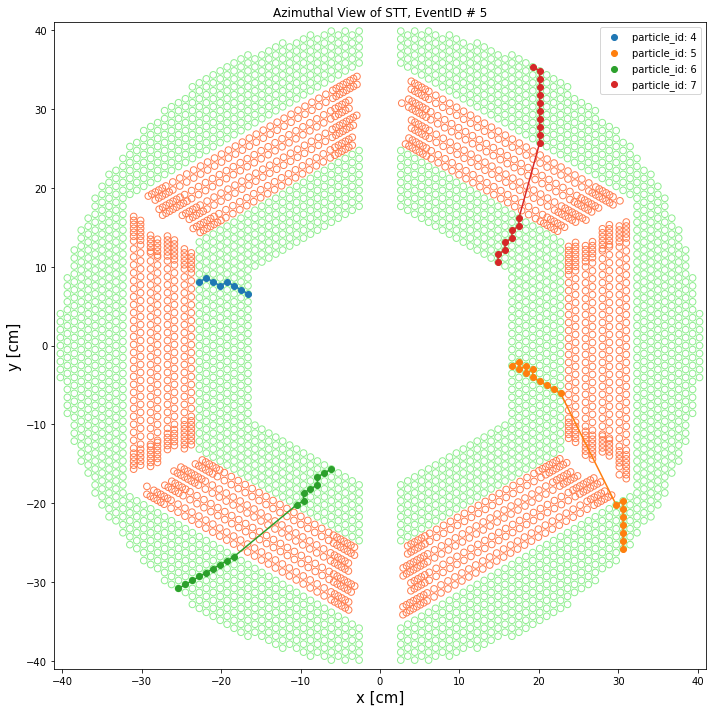

In [96]:
# plot true event
fig, ax = detector_layout(figsize=(10,10))
e_id = int(true_track.event_file[-10:])
p_ids = np.unique(true_track.pid)

for pid in p_ids:
    idx = true_track.pid == pid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], label='particle_id: {}'.format(int(pid)))

ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("true_track.png")

In [97]:
reco_track = reco_trkx_data

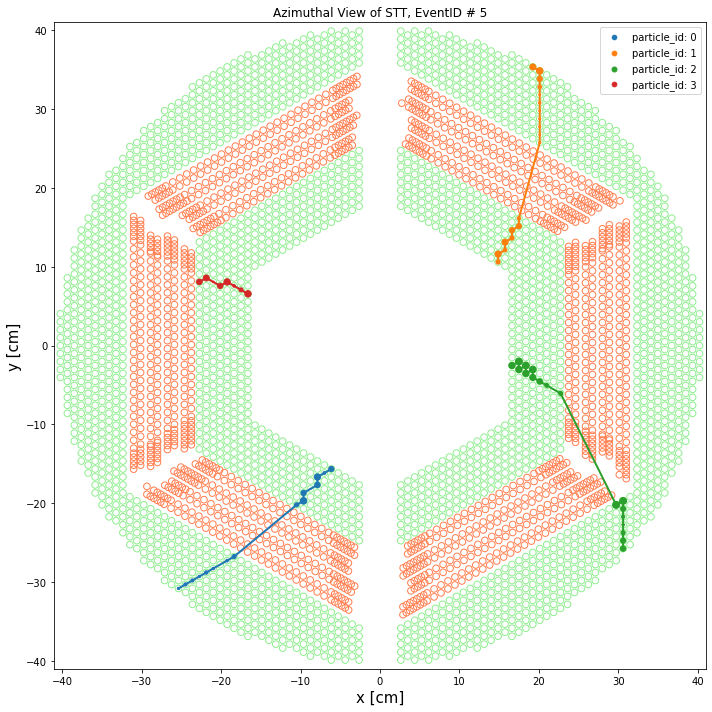

In [98]:
# plot reco event, here, (x,y,ir) comes from ture event. but idx is from reco event
fig, ax = detector_layout(figsize=(10,10))
e_id = e_id
t_ids = np.unique(reco_track.track_id)

for tid in t_ids:
    idx = reco_track.track_id == tid
    ax.plot(x[idx], y[idx], '-', linewidth=2)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*100), label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("reco_track.png")

### _Read HDF5_

In [109]:
import pandas as pd

In [112]:
path = "../run_all/fwp_gnn_segmenting/eval/all_particles.h5"
store = pd.HDFStore(path)

In [113]:
# store.get('data').head()
store['data'].head()

,particle_id,pt,vx,vy,vz,q,pdgcode,theta,eta,n_true_hits,is_matched,is_trackable,evtid
0,6,0.205157,-1.854500,-0.415320,8.052530,1,2212,0.443487,1.489653,8,True,True,0
1,5,0.128648,2.395160,0.536402,6.411090,1,211,0.457441,1.457602,16,True,True,0
0,5,0.101602,-1.338330,1.013940,8.682130,1,211,0.451942,1.470122,11,True,True,1
1,6,0.275242,0.134011,-0.101529,0.468718,1,2212,0.501526,1.361974,14,True,True,1
0,5,0.114144,1.320080,0.160395,18.215401,1,211,0.447746,1.479773,23,True,True,10


In [114]:
store.close()